In [38]:
%load_ext autoreload
%autoreload 2
import os

from util import *
from util import _scale_eps, _run_test

log_dir = 'new_experiment_log/'
if not os.path.isdir(log_dir):
    os.mkdir(log_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# import aif360.datasets.noisy_dataset as noisy
# import noisyfair.algorithms as denoisedfair
# from aif360.datasets import BinaryLabelDataset
# from aif360.datasets import AdultDataset, CompasDataset
# from aif360.metrics import BinaryLabelDatasetMetric
# from aif360.metrics import ClassificationMetric
# from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_compas
import numpy as np

import random
from copy import deepcopy
random.seed()

from tqdm.notebook import tqdm

# insert flipping noises in the selected feature
def flipping(feature_names, features, name, eta0, eta1):
    index = feature_names.index(name)
    N = features.shape[0]
    noisyfea = deepcopy(features[:,index])
    count = 0
    for i in range(N):
        seed = random.random()
        if int(features[i][index]) == 1:
            if seed < eta1:
                noisyfea[i] = 1 - noisyfea[i]
                count += 1
        elif int(features[i][index]) == 0:
            if seed < eta0:
                noisyfea[i] = 1 - noisyfea[i]
                count += 1
    print('Count_flipping:', count)
    return index, noisyfea

class LeastSquaresLearner:
    def __init__(self):
        self.weights = None

    def fit(self, X, Y, W):
        sqrtW = np.sqrt(W)
        matX = np.array(X) * sqrtW[:, np.newaxis]
        vecY = Y * sqrtW
        self.lsqinfo = np.linalg.lstsq(matX, vecY, rcond=-1)
        self.weights = pd.Series(self.lsqinfo[0], index=list(X))

    def predict(self, X):
        pred = X.dot(self.weights)
        return 1*(pred > 0.5)



In [71]:
keys = ["disp_train", "disp_test", "sr_train", "sr_test", "error_train", "error_test", "acc_train", "acc_test"]

def _experiment(dataset_train, train_labels, dataset_test, tests, rho, trials, sensible_name, sensible_feature, creteria, classifier, include_sensible, learner, n, verbose):
    '''
    Internal rountine of running experiment. Run experiments under different settings using different algorithms and collect the results returned by the invoked fair classifiers.
    '''

#     if mode == 'six':
#         n = 6
#     else:
#         n = 4
    all_data = [{k:[[] for _ in range(trials)] for k in keys} for _ in range(n)]

    start = time.time()

    for i in range(trials):
        print('trial:', i, 'time:', time.time()-start)
#         dataset_train, dataset_test = permute_and_split(datamat)
        data_cor = change_format_new(dataset_train, train_labels, dataset_test, sensible_feature, include_sensible)

#         dataY = data_nocor[1]
#         dataA = data_nocor[2]
#         cor_dataA = dataA.copy()
#         data_cor = copy.deepcopy(data_nocor)

#         corrupt(cor_dataA, data_nocor[1], rho, creteria)
#         data_cor[2] = cor_dataA

        cor_dataA = data_cor[2]
        dataY = data_cor[1]
        
        data_denoised, data_denoised_est, rho_est = denoiseA(data_cor, rho, mode)

        alpha_a, beta_a = estimate_alpha_beta(cor_dataA, dataY, rho, creteria)

#         if mode == 'six':
#             alpha_a_est, beta_a_est = estimate_alpha_beta(cor_dataA, dataY, rho_est, creteria)

        for test_0 in tqdm(tests):
            eps_0 = test_0['eps']
            test = copy.deepcopy(test_0)

#             res_cor = _run_test(test, data_cor, sensible_name, learner, creteria, verbose, classifier)

#             res_nocor = _run_test(test, data_nocor, sensible_name, learner,  creteria, verbose, classifier)

#             res_denoised = _run_test(test, data_denoised, sensible_name, learner,  creteria, verbose, classifier)

            test['eps'] = _scale_eps(eps_0, alpha_a, beta_a)
            res_cor_scale = _run_test(test, data_cor, sensible_name, learner, creteria, verbose, classifier)
            print (eps_0, res_cor_scale['sr_test'], res_cor_scale['acc_test'])
            results = [res_cor_scale]

#             if mode == 'six':
#                 test['eps'] = _scale_eps(eps_0, alpha_a_est, beta_a_est)
#                 res_cor_scale_est = _run_test(test, data_cor, sensible_name, learner, creteria, verbose, classifier)

#                 test['eps'] = eps_0
#                 res_denoised_est = _run_test(test, data_denoised_est, sensible_name, learner, creteria, verbose, classifier)

#                 results = [res_cor, res_nocor, res_denoised, res_cor_scale, res_denoised_est, res_cor_scale_est]

            for k in keys:
                for j in range(n):
                    all_data[j][k][i].append(results[j][k])

    return all_data


In [73]:
%%time

import warnings
warnings.filterwarnings("ignore")

dataset = 'adult'
eps = None
rho_list = None
eps_list = [0.0015 * i for i in range(1, 10)]
# rho_list = [[0.06*i, 0.06*i] for i in range(8)] # Privacy

# rho = [0.15, 0.15]
# eps_list = [0.02 * i for i in range(1, 11)]
frac = 1
eval_objective = 'test_tau'
criteria = 'DP'
classifier = 'Agarwal'
trials = 1
include_sensible = False
filename = log_dir+'all_data_'+dataset+','+str(rho[0])+','+str(rho[1])+','+str(frac)+','+criteria \
           +','+classifier+','+str(trials)+','+str(include_sensible)+','+eval_objective+'.pickle'
learner_name = 'lsq'
mode = 'four'
verbose = False


datamat = load_preproc_data_adult()

sensible_name = 'race'
#     privileged_groups = [{protected_name: 1}]
#     unprivileged_groups = [{protected_name: 0}]

dataset_train, dataset_test = datamat.split([0.7], shuffle=True)
eta0 = 0.1
eta1 = 0.3
rho = [eta1, eta0]
index, noisyfea = flipping(dataset_train.feature_names, dataset_train.features, sensible_name, eta0, eta1)

dataset_noisy = np.copy(dataset_train.features)
dataset_noisy[:,index] = noisyfea
dataset_noisy = np.array(dataset_noisy)
print (dataset_noisy)
train_labels = [int(lab[0]) for lab in dataset_train.labels]

learner = LeastSquaresLearner()
eps_list = [0.005 * i for i in range(1, 20)]
tests = [{"cons_class": moments.DP, "eps": eps} for eps in eps_list]

all_data = _experiment(dataset_noisy, train_labels, dataset_test, tests, rho, trials, sensible_name, index, criteria, classifier, include_sensible, learner, 1, verbose)
# _save_all_data(filename, all_data, eps_list)

# all_data = experiment(dataset, frac, eval_objective, eps, rho_list, rho, eps_list, criteria, classifier, trials, include_sensible, filename, learner_name, mode, verbose)


Count_flipping: 9241
[[1. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
trial: 0 time: 2.1457672119140625e-06


None 0.9948260121263105 0.29605350037864653
None 0.9875967667602943 0.35479964212871773
None 0.9810490902830091 0.40593842854833184
None 0.9715946125539124 0.4608808958354057
None 0.9594593405093778 0.5158233608082852
None 0.9433147202477622 0.5707658256787036
None 0.9207806043979673 0.625708291727419
None 0.8871281084222674 0.6806507560521041
None 0.8314336132576371 0.7355932211401001
None 0.7214953356704561 0.7905356862435136
None 0.6798951770281572 0.802975499897632
None 0.6798951770281572 0.802975499897632
None 0.6798951770281572 0.802975499897632



KeyboardInterrupt: 

In [74]:
list(zip(all_data[0]['sr_test'][0], all_data[0]['acc_test'][0]))

[(0.8979218308977903, 0.6698193214090473),
 (0.6995374405041228, 0.797857094110421),
 (0.6995374405041228, 0.797857094110421),
 (0.6995374405041228, 0.797857094110421),
 (0.6995374405041228, 0.797857094110421),
 (0.6995374405041228, 0.797857094110421),
 (0.6995374405041228, 0.797857094110421),
 (0.6995374405041228, 0.797857094110421),
 (0.6995374405041228, 0.797857094110421)]

Text(0, 0.5, 'Accuracy')

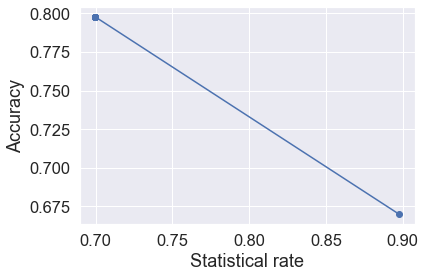

In [75]:
plt.plot(all_data[0]['sr_test'][0], all_data[0]['acc_test'][0], "-o")
plt.xlabel("Statistical rate")
plt.ylabel("Accuracy")

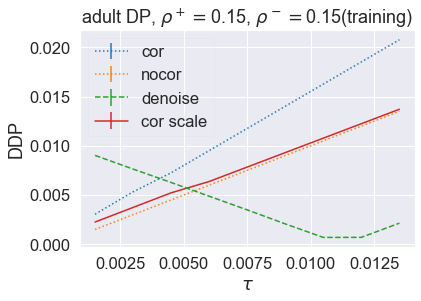

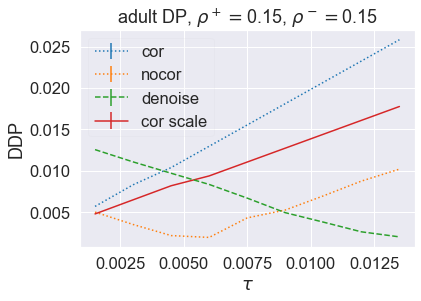

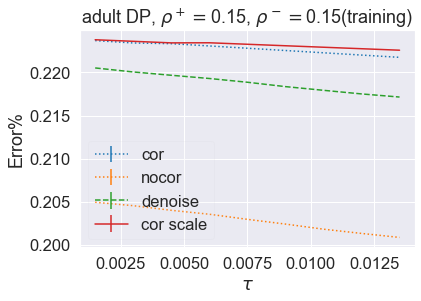

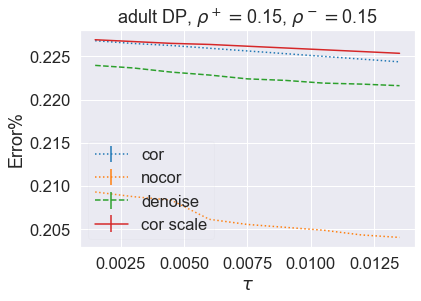

In [33]:
plot(filename, eval_objective, save=False)

In [ ]:
dataset = 'COMPAS'
eps = None
rho_list = None

rho = [0.15, 0.15]
eps_list = [0.02 * i for i in range(1, 11)]
frac = 1
eval_objective = 'test_tau'
criteria = 'DP'
classifier = 'Agarwal'
trials = 1
include_sensible = False
filename = log_dir+'all_data_'+dataset+','+str(rho[0])+','+str(rho[1])+','+str(frac)+','+criteria \
           +','+classifier+','+str(trials)+','+str(include_sensible)+','+eval_objective+'.pickle'
learner_name = 'lsq'
mode = 'four'
verbose = False
all_data = experiment(dataset, frac, eval_objective, eps, rho_list, rho, eps_list, criteria, classifier, trials, include_sensible, filename, learner_name, mode, verbose)
